In [2]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_actual_power, market_name_dict
# from private.db.tencnet.openmeteo.china_weather_forecast import ProvinceForecastData, forecast_slice
from private.db.tencnet.openmeteo.china_opemmeteo_forecast2 import ProvinceForecastData, forecast_slice

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla import VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt

from data_utils.serial_utils.series_trans_utils import MinMax

In [3]:
with open(f"E:\\code\\github\\private\\private\\db\\tencnet\\openmeteo\\data\\shanx_{TimeStamp(2024, 10, 1).get_date_string()}_5.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

In [4]:
print(pfd.forecast_timestamp)
print(pfd.next_forecast_range(1))
print(pfd.next_forecast_range(2))

2024-10-01 00:00:00
[1727798400.0, 1727884799.0]
[1727798400.0, 1727971199.0]


In [5]:
cma_long = pfd.ecmwf_forecast_morning_matrix
# cma_long = pfd.cma_grid_forecast[0]
cma = forecast_slice(cma_long, pfd, 1)
cma_test = forecast_slice(cma_long, pfd, 2)
print([TimeStamp(i).get_date_string() for i in cma[:,0]])
print([TimeStamp(i).get_date_string() for i in cma_test[:,0]])

['2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02']
['2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-02', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '2024-10-03', '202

In [6]:
print(cma.shape)
print(cma_test.shape)
print(cma_long.shape)

(24, 1175)
(48, 1175)
(480, 1175)


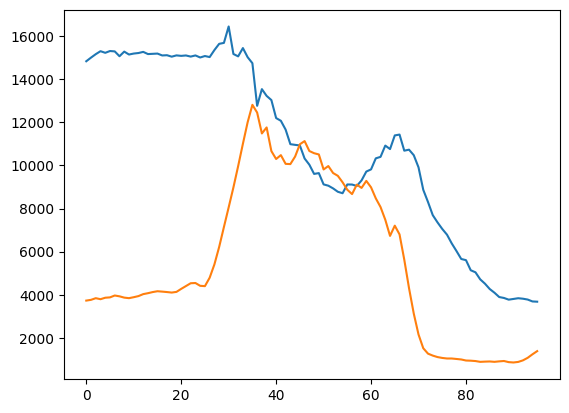

In [7]:
actual = market_actual_power(market_name_dict["shanxi"], TimeStamp(2024, 10, 1).get_date_string())
actual_test = market_actual_power(market_name_dict["shanxi"], TimeStamp(2024, 10, 2).get_date_string())
plt.plot(actual["power"])
plt.plot(actual_test["power"])

In [8]:
actual = actual.aggregate(["hour", 1], numpy.sum, align=True, align_domain=["2024-10-1", "2024-10-2"])
actual_test = actual_test.aggregate(["hour", 1], numpy.sum, align=True, align_domain=["2024-10-2", "2024-10-3"])
print(actual["power"])

[60300.927 60893.376 60835.455 60805.662 60370.406 60340.797 60467.911
 62946.453 60272.054 52565.952 46919.105 42239.424 37432.643 35542.363
 37184.032 41467.218 44271.074 39988.081 30408.621 24859.172 20500.031
 16770.711 15269.873 14963.847]


In [9]:
x = numpy.apply_along_axis(MinMax.g, axis=0, arr=cma)
x_test = numpy.apply_along_axis(MinMax.g, axis=0, arr=cma_test)
# x = MinMax.f(ecmwf)
xt = torch.Tensor(x)
xt_test = torch.Tensor(x_test)
yt = torch.Tensor(MinMax.g(actual["power"]))
y_test = torch.Tensor(actual_test["power"])
print(xt.shape)
print(yt.shape)
print(cma[0])

torch.Size([24, 1175])
torch.Size([24])
[ 1.72779840e+09  2.02400000e+03  1.00000000e+01 ...  9.95610112e-01
  0.00000000e+00 -9.63968229e-03]


In [10]:
input_size = xt.shape[1]
d_model = 1024
nhead = 128
output_size = 1
num_layers = 4
batch_size = 6
lr = 1e-6
model = VanillaTransformer(
    input_size,
    output_size,
    num_layers,
    d_model,
    nhead,
    dropout=0.0
)
trained_model = vanilla_transformer_trainer(model, xt, yt, batch_size, 100, lr=lr)

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


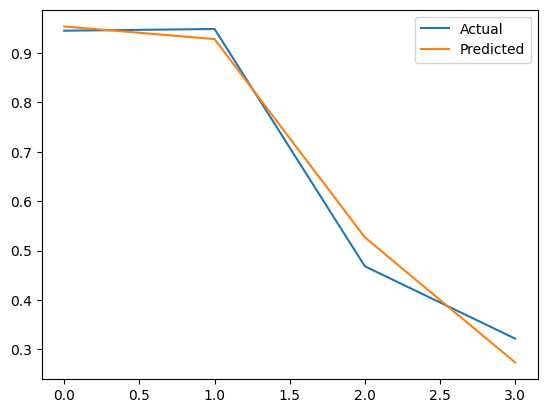

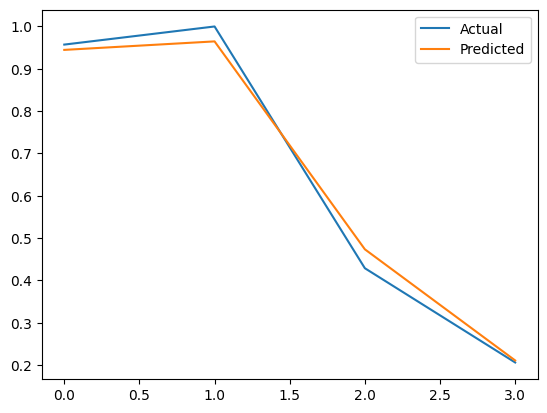

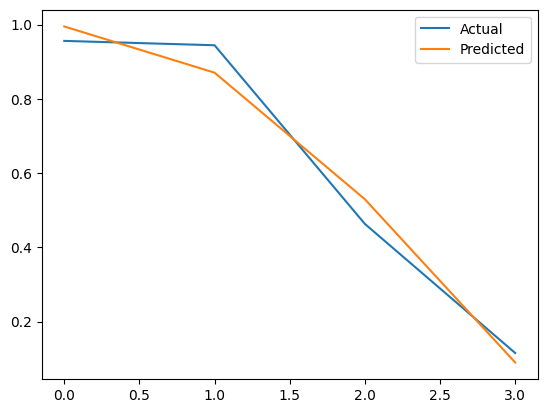

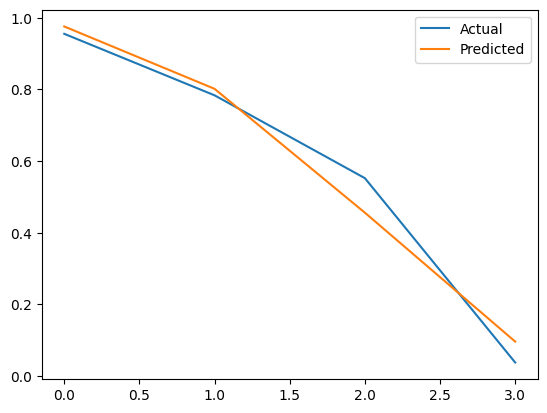

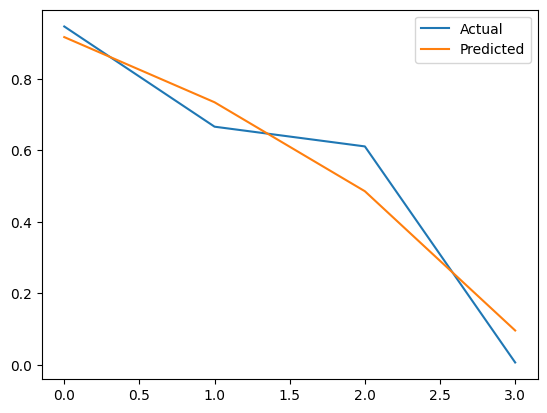

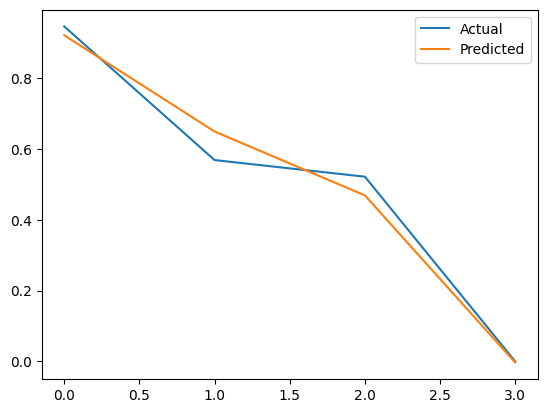

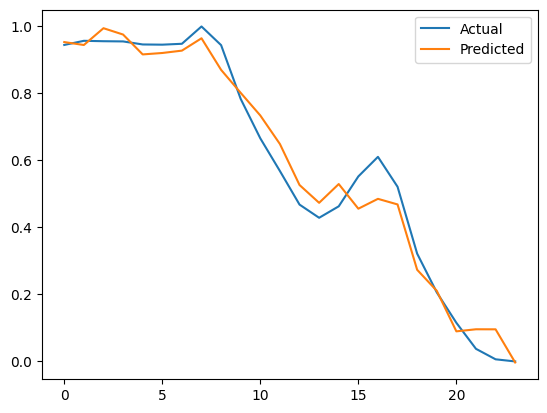

In [11]:
p = vanilla_transformer_tester(trained_model, xt, batch_size)
for _ in range(batch_size):
    plt.plot(yt.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p[:,_], label='Predicted')
    # plt.plot(p[:,1], label='Predicted')
    plt.legend()
    plt.show()

plt.plot(yt.reshape(-1), label='Actual')
plt.plot(p.reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

In [67]:
print(p.reshape(-1).tolist())
print(yt.reshape(-1).numpy().tolist())

[1.5501750707626343, 1.5770188570022583, 1.5946162939071655, 1.672481656074524, 1.8055920600891113, 1.8261305093765259, 1.790188193321228, 1.8995988368988037, 1.8048760890960693, 1.8248871564865112, 1.7312477827072144, 1.7302026748657227, 1.6102718114852905, 1.6754586696624756, 1.5757075548171997, 1.6261247396469116, 1.5897303819656372, 1.6256201267242432, 1.6075905561447144, 1.663347601890564, 1.7157154083251953, 1.6866713762283325, 1.677687644958496, 1.6587694883346558, 1.5110197067260742, 1.5563968420028687, 1.4623193740844727, 1.5131298303604126, 1.5037952661514282, 1.4945579767227173, 1.558591365814209, 1.5730631351470947, 1.5856873989105225, 1.6543874740600586, 1.6283262968063354, 1.704172134399414, 1.6759229898452759, 1.6826175451278687, 1.7507258653640747, 1.7259266376495361, 1.7917331457138062, 1.7354074716567993, 1.8346161842346191, 1.8375585079193115, 1.8526946306228638, 1.8417531251907349, 1.7711660861968994, 1.7515239715576172]
[60300.92578125, 60893.375, 60835.453125, 608

In [68]:
print(x[0].tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28846153846153844, 0.35026873010870746, 0.3167701863354037, 0.750955179623356, 0.2991202346041056, 0.8396595109112224, 0.25761772853185594, 0.11897644987996063, 0.26133333333333336, 0.620341372885824, 0.26133333333333336, 0.8601992411188729, 0.26133333333333336, 0.9036625278859544, 0.2427440633245383, 0.8775743984362335, 0.18421052631578946, 0.6606876739616379, 0.15544041450777202, 0.0, 0.0, 0.9584286997490481, 0.12736473944319224, 0.16543469682057077, 0.5728111729995923, 0.1345584392368956, 0.16047500891880034, 0.527958225107747, 0.13637278893324709, 0.15497621593439304, 0.528488498330265, 0.14865444557758964, 0.14593011570687245, 0.02214238601318021, 0.1501203150022662, 0.14593011570687245, 0.544072090059629, 0.1199122398182901, 0.17997329452756494, 0.36946665724764877, 0.11150837530686376, 0.17894666820572977, 0.6186322309746769, 0.11150837530686376, 0.17894666820572977, 0.2927073494138394, 0.1158280880035684, 0.17812867563362883, 1.0, 0.098300460176

In [69]:
sin_x0 = numpy.arange(-6,6,0.1)
sin_x1 = numpy.cos(numpy.arange(-6,6,0.1))
sin_x =  torch.Tensor(numpy.column_stack((sin_x0, sin_x1)))
sin_y = torch.Tensor(numpy.sin(numpy.arange(-6,6,0.1)))
sin_m = VanillaTransformer(2, 1, 2, 8, 2)
sine_m_ed = vanilla_transformer_trainer(sin_m, sin_x, sin_y, 10, 100)

100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


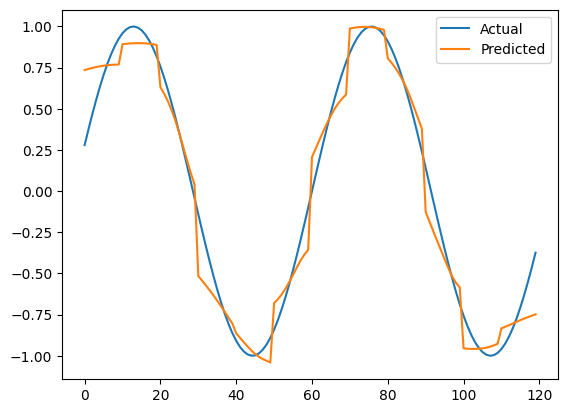

In [70]:
sin_p = vanilla_transformer_tester(sine_m_ed,sin_x, 10).reshape(-1).numpy()
plt.plot(sin_y.reshape(-1), label='Actual')
plt.plot(sin_p.reshape(-1), label='Predicted')
plt.legend()
plt.show()

In [71]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=0)
reg.fit(xt.numpy(), yt.numpy())


ExtraTreesRegressor(random_state=0)

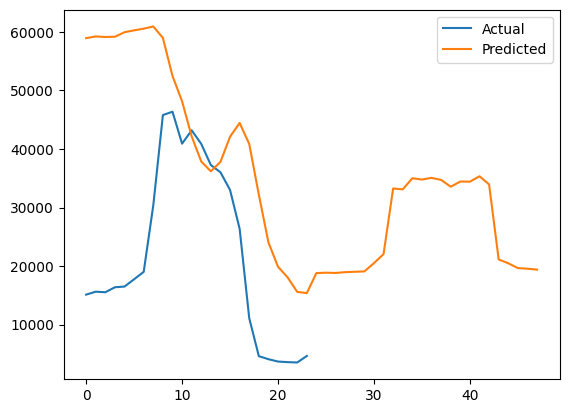

In [72]:
plt.plot(y_test.numpy(), label='Actual')
plt.plot(reg.predict(x_test), label='Predicted')
plt.legend()
plt.show()